In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time, os

import random
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats


import folium
from folium.plugins import FastMarkerCluster
#https://peterhaas-me.medium.com/how-to-geocode-with-python-and-pandas-4cd1d717d3f7
#https://towardsdatascience.com/geocode-with-python-161ec1e62b89

import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
df = pd.read_pickle("housing_zip.pkl")
housing_data = pd.read_pickle("housing_data.pkl")
zip_data = pd.read_pickle("zip_data.pkl")

In [3]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { height:100% !important; }</style>"))

mapa = folium.Map(location=(34.02,-118.28406536660198), zoom_start=9)
for index, row in df.iterrows():
    folium.Marker(location=(row['lat'],row['long'])).add_to(mapa)
display(mapa)

In [4]:
folium_map = folium.Map(location=[34.02,-118.28406536660198],
                        zoom_start=10,
                        tiles='CartoDB dark_matter')
FastMarkerCluster(data=list(zip(df['lat'].values, df['long'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map

In [5]:
housing_data.head()

,address,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old,price
0,"1135 W 185th St, Gardena, CA 90248, USA",1866.0,3.0,3.0,0.0,1,0,1,0,67.0,800000.0
1,"9631 Compton Ave, Los Angeles, CA 90002, USA",1522.0,4.0,3.0,0.0,1,0,1,0,0.0,610000.0
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 902...",1785.0,3.0,3.0,460.0,1,1,0,0,57.0,1125000.0
4,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",1626.0,3.0,3.0,0.0,1,0,0,1,40.0,542300.0
5,"21917 Lopez St, Woodland Hills, CA 91364, USA",1014.0,3.0,1.0,0.0,0,0,1,0,72.0,902000.0


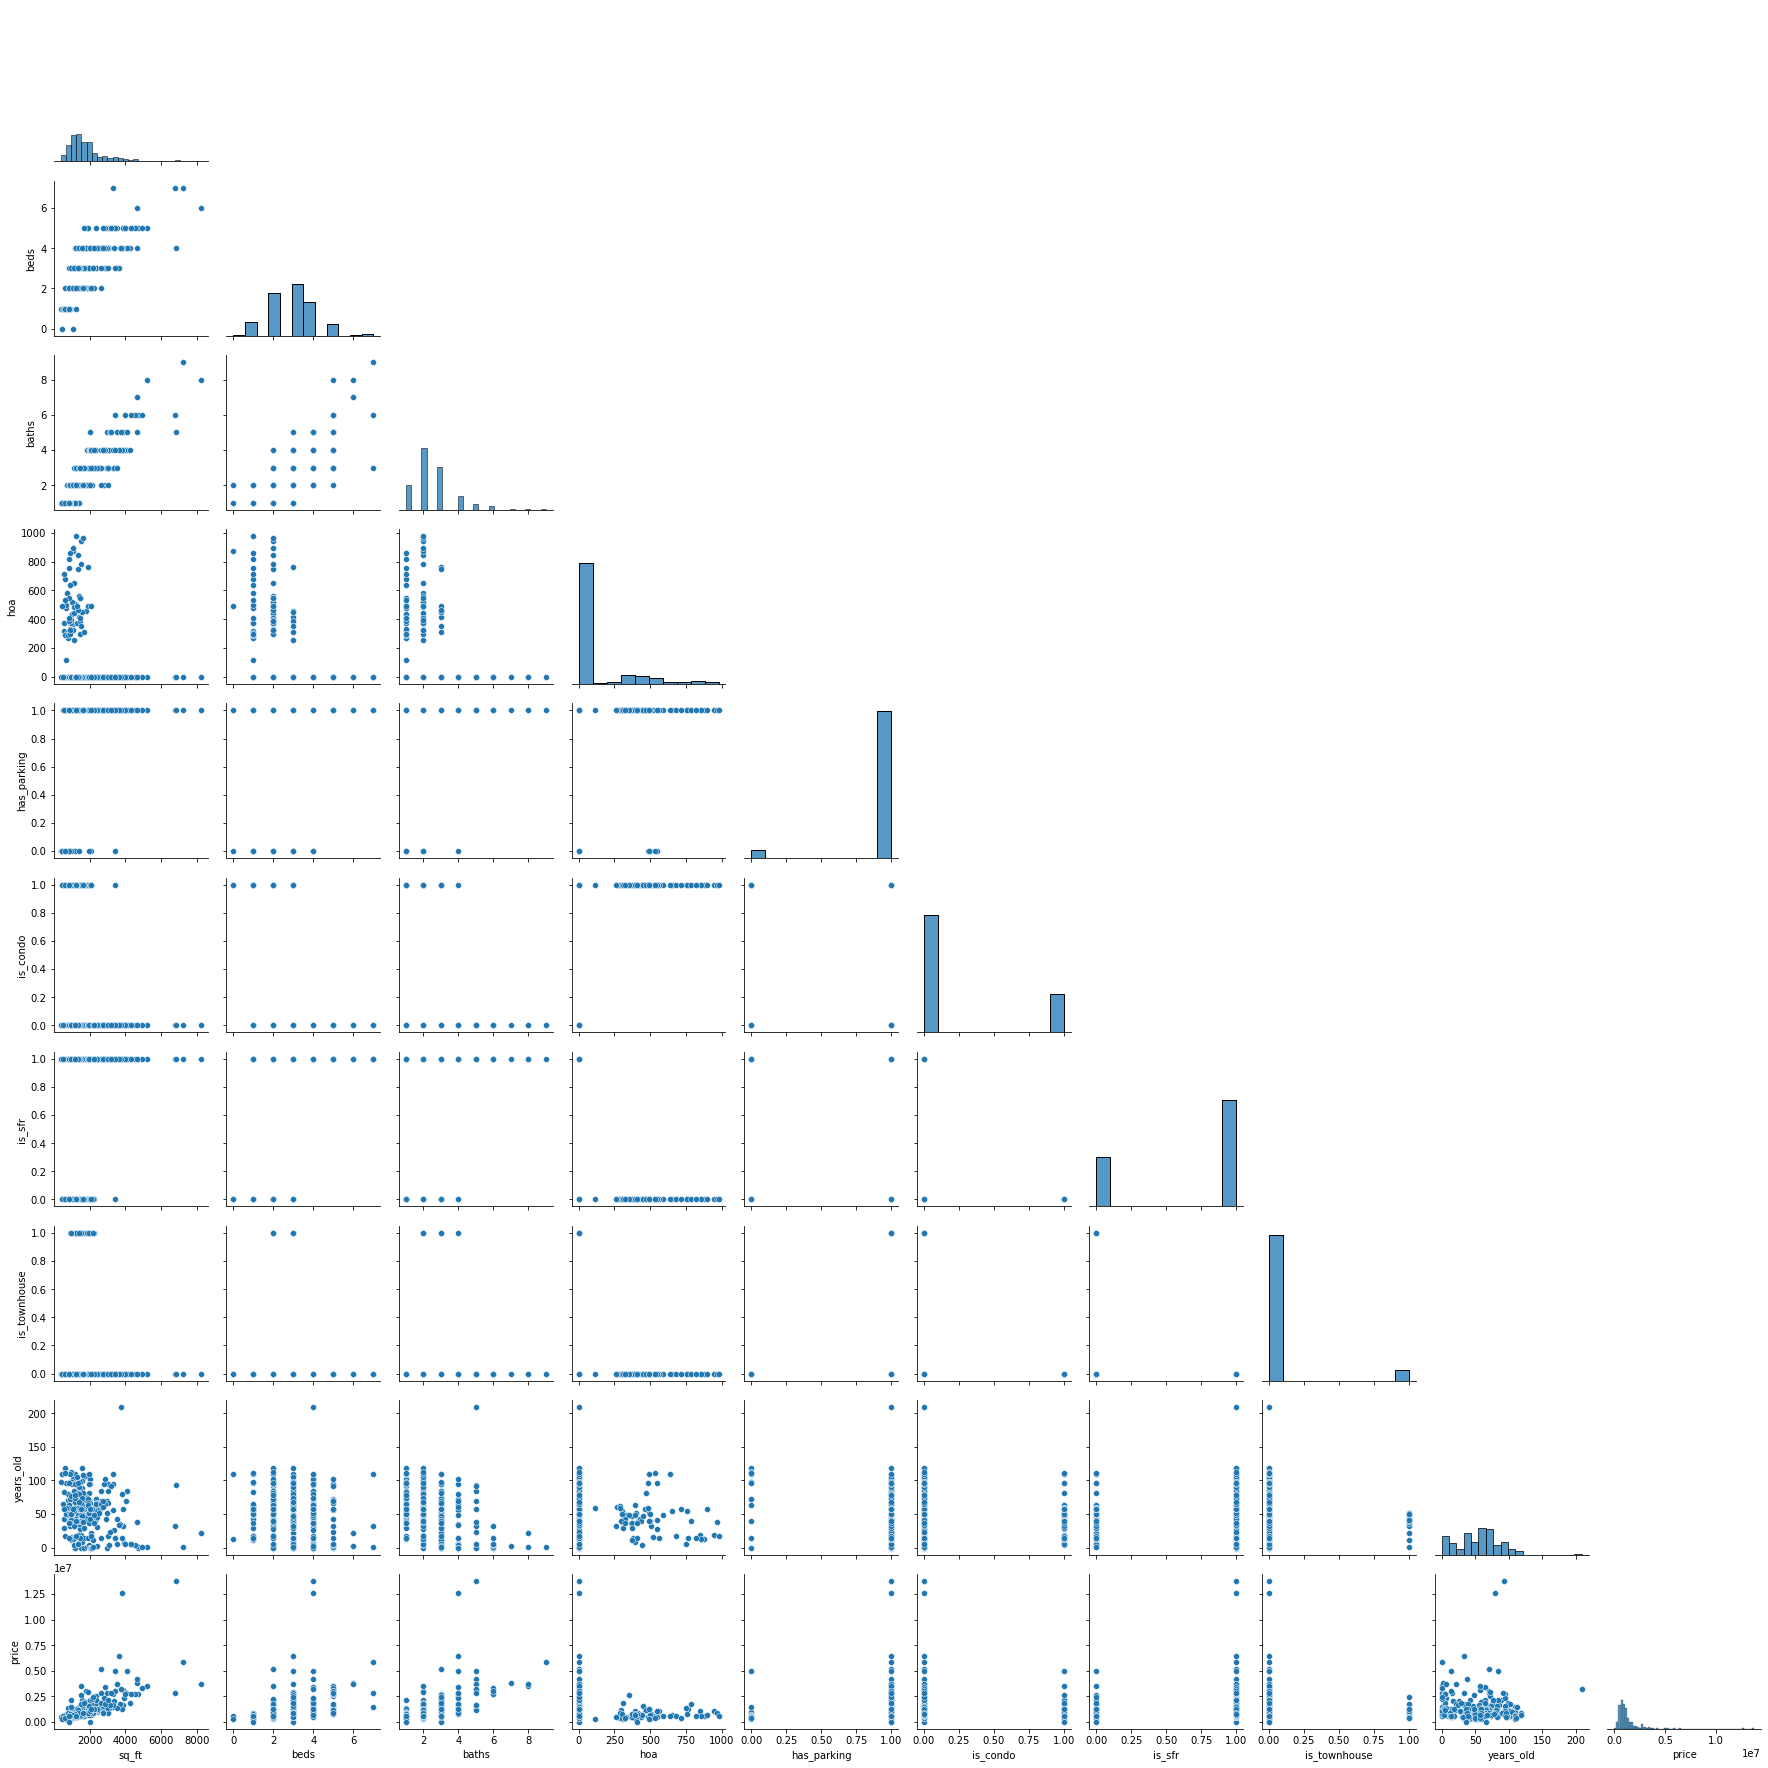

In [6]:
sns.pairplot(housing_data, corner=True);

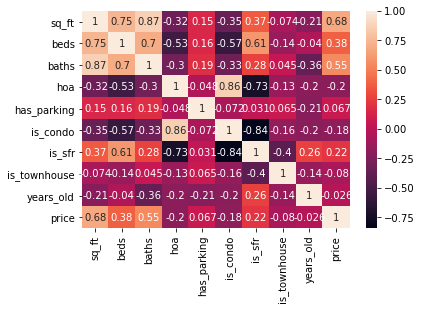

In [7]:
corrMatrix = housing_data.corr()
sns.heatmap(corrMatrix, annot=True);

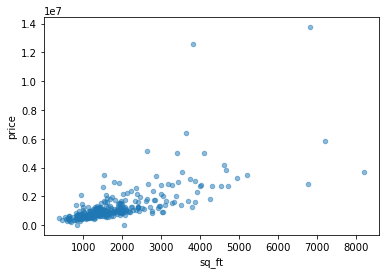

In [8]:
housing_data.plot('sq_ft', 'price', kind='scatter', alpha=0.5);

## Run First Linear Model with Only Home Features

In [9]:
housing_data.shape

(292, 11)

In [10]:
X_housing = housing_data.drop(['address', 'price'], axis =1)
y_housing = housing_data['price']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_housing, y_housing, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))

OLS
Train:  0.579
Val:  0.235


## Run Linear Model with Geographic Features

In [11]:
df.shape

(292, 22)

In [12]:
df[df.median_income.isnull()]

,address,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old,...,median_age,avg_household,median_income,pct_poverty,pct_bachelors,url,zip_usa,gcode,lat,long
81,"13200 Pacific Promenade APT 318, Playa Vista, ...",642.0,1.0,1.0,679.0,1,1,0,0,18.0,...,36.6,2.2,NaN,7.4,84.2,http://www.city-data.com/zips/90094.html,"90094, USA","(Playa Vista, Los Angeles, California, 90094, ...",33.976670,-118.417370
113,"7100 Playa Vista Dr APT 403, Playa Vista, CA 9...",1892.0,3.0,3.0,763.0,1,1,0,0,14.0,...,36.6,2.2,NaN,7.4,84.2,http://www.city-data.com/zips/90094.html,"90094, USA","(Playa Vista, Los Angeles, California, 90094, ...",33.976670,-118.417370
259,"11000 Burin Ave, Inglewood, CA 90304, USA",392.0,1.0,1.0,0.0,0,0,1,0,97.0,...,30.5,3.9,NaN,12.9,10.6,http://www.city-data.com/zips/90304.html,"90304, USA","(Inglewood, California, 90304, United States, ...",33.957281,-118.363443
263,"9702 S 7th Ave, Inglewood, CA 90305, USA",1399.0,3.0,2.0,0.0,1,0,1,0,80.0,...,46.7,2.5,NaN,5.3,34.2,http://www.city-data.com/zips/90305.html,"90305, USA","(Inglewood, California, 90305, United States, ...",33.960649,-118.328915
266,"4058 W 107th St, Inglewood, CA 90304, USA",1590.0,4.0,2.0,0.0,1,0,1,0,74.0,...,30.5,3.9,NaN,12.9,10.6,http://www.city-data.com/zips/90304.html,"90304, USA","(Inglewood, California, 90304, United States, ...",33.957281,-118.363443
268,"10136 S Inglewood Ave, Inglewood, CA 90304, USA",529.0,1.0,1.0,0.0,1,0,1,0,65.0,...,30.5,3.9,NaN,12.9,10.6,http://www.city-data.com/zips/90304.html,"90304, USA","(Inglewood, California, 90304, United States, ...",33.957281,-118.363443
275,"2528 W 76th St, Inglewood, CA 90305, USA",1340.0,3.0,2.0,0.0,1,0,1,0,96.0,...,46.7,2.5,NaN,5.3,34.2,http://www.city-data.com/zips/90305.html,"90305, USA","(Inglewood, California, 90305, United States, ...",33.960649,-118.328915
276,"9826 S 8th Ave, Inglewood, CA 90305, USA",1176.0,2.0,1.0,0.0,1,0,1,0,78.0,...,46.7,2.5,NaN,5.3,34.2,http://www.city-data.com/zips/90305.html,"90305, USA","(Inglewood, California, 90305, United States, ...",33.960649,-118.328915


In [13]:
df.loc[[81, 113], 'median_income'] = 119658.0
df.loc[[259, 263, 266, 268, 275, 276], 'median_income'] = 54400.0

In [14]:
#move `price` column to the end of dataframe 
df= df[[c for c in df if c not in ['price']] + ['price']]
df.head()

,address,sq_ft,beds,baths,hoa,has_parking,is_condo,is_sfr,is_townhouse,years_old,...,avg_household,median_income,pct_poverty,pct_bachelors,url,zip_usa,gcode,lat,long,price
0,"1135 W 185th St, Gardena, CA 90248, USA",1866.0,3.0,3.0,0.0,1,0,1,0,67.0,...,3.0,64253.0,9.7,27.9,http://www.city-data.com/zips/90248.html,"90248, USA","(Harbor Gateway, California, 90248, United Sta...",33.881499,-118.284065,800000.0
1,"9631 Compton Ave, Los Angeles, CA 90002, USA",1522.0,4.0,3.0,0.0,1,0,1,0,0.0,...,4.1,38987.0,28.8,6.1,http://www.city-data.com/zips/90002.html,"90002, USA","(Florence-Firestone, Firestone Park, Californi...",33.954675,-118.248034,610000.0
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 902...",1785.0,3.0,3.0,460.0,1,1,0,0,57.0,...,1.9,110698.0,5.8,74.7,http://www.city-data.com/zips/90293.html,"90293, USA","(Playa del Rey, Los Angeles, California, 90293...",33.959733,-118.438432,1125000.0
3,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",1626.0,3.0,3.0,0.0,1,0,0,1,40.0,...,3.1,73724.0,11.7,31.5,http://www.city-data.com/zips/91304.html,"91304, USA","(Los Angeles, California, 91304, United States...",34.218093,-118.614535,542300.0
4,"21917 Lopez St, Woodland Hills, CA 91364, USA",1014.0,3.0,1.0,0.0,0,0,1,0,72.0,...,2.6,111075.0,5.5,55.5,http://www.city-data.com/zips/91364.html,"91364, USA","(Los Angeles, California, 91364, United States...",34.165288,-118.610120,902000.0


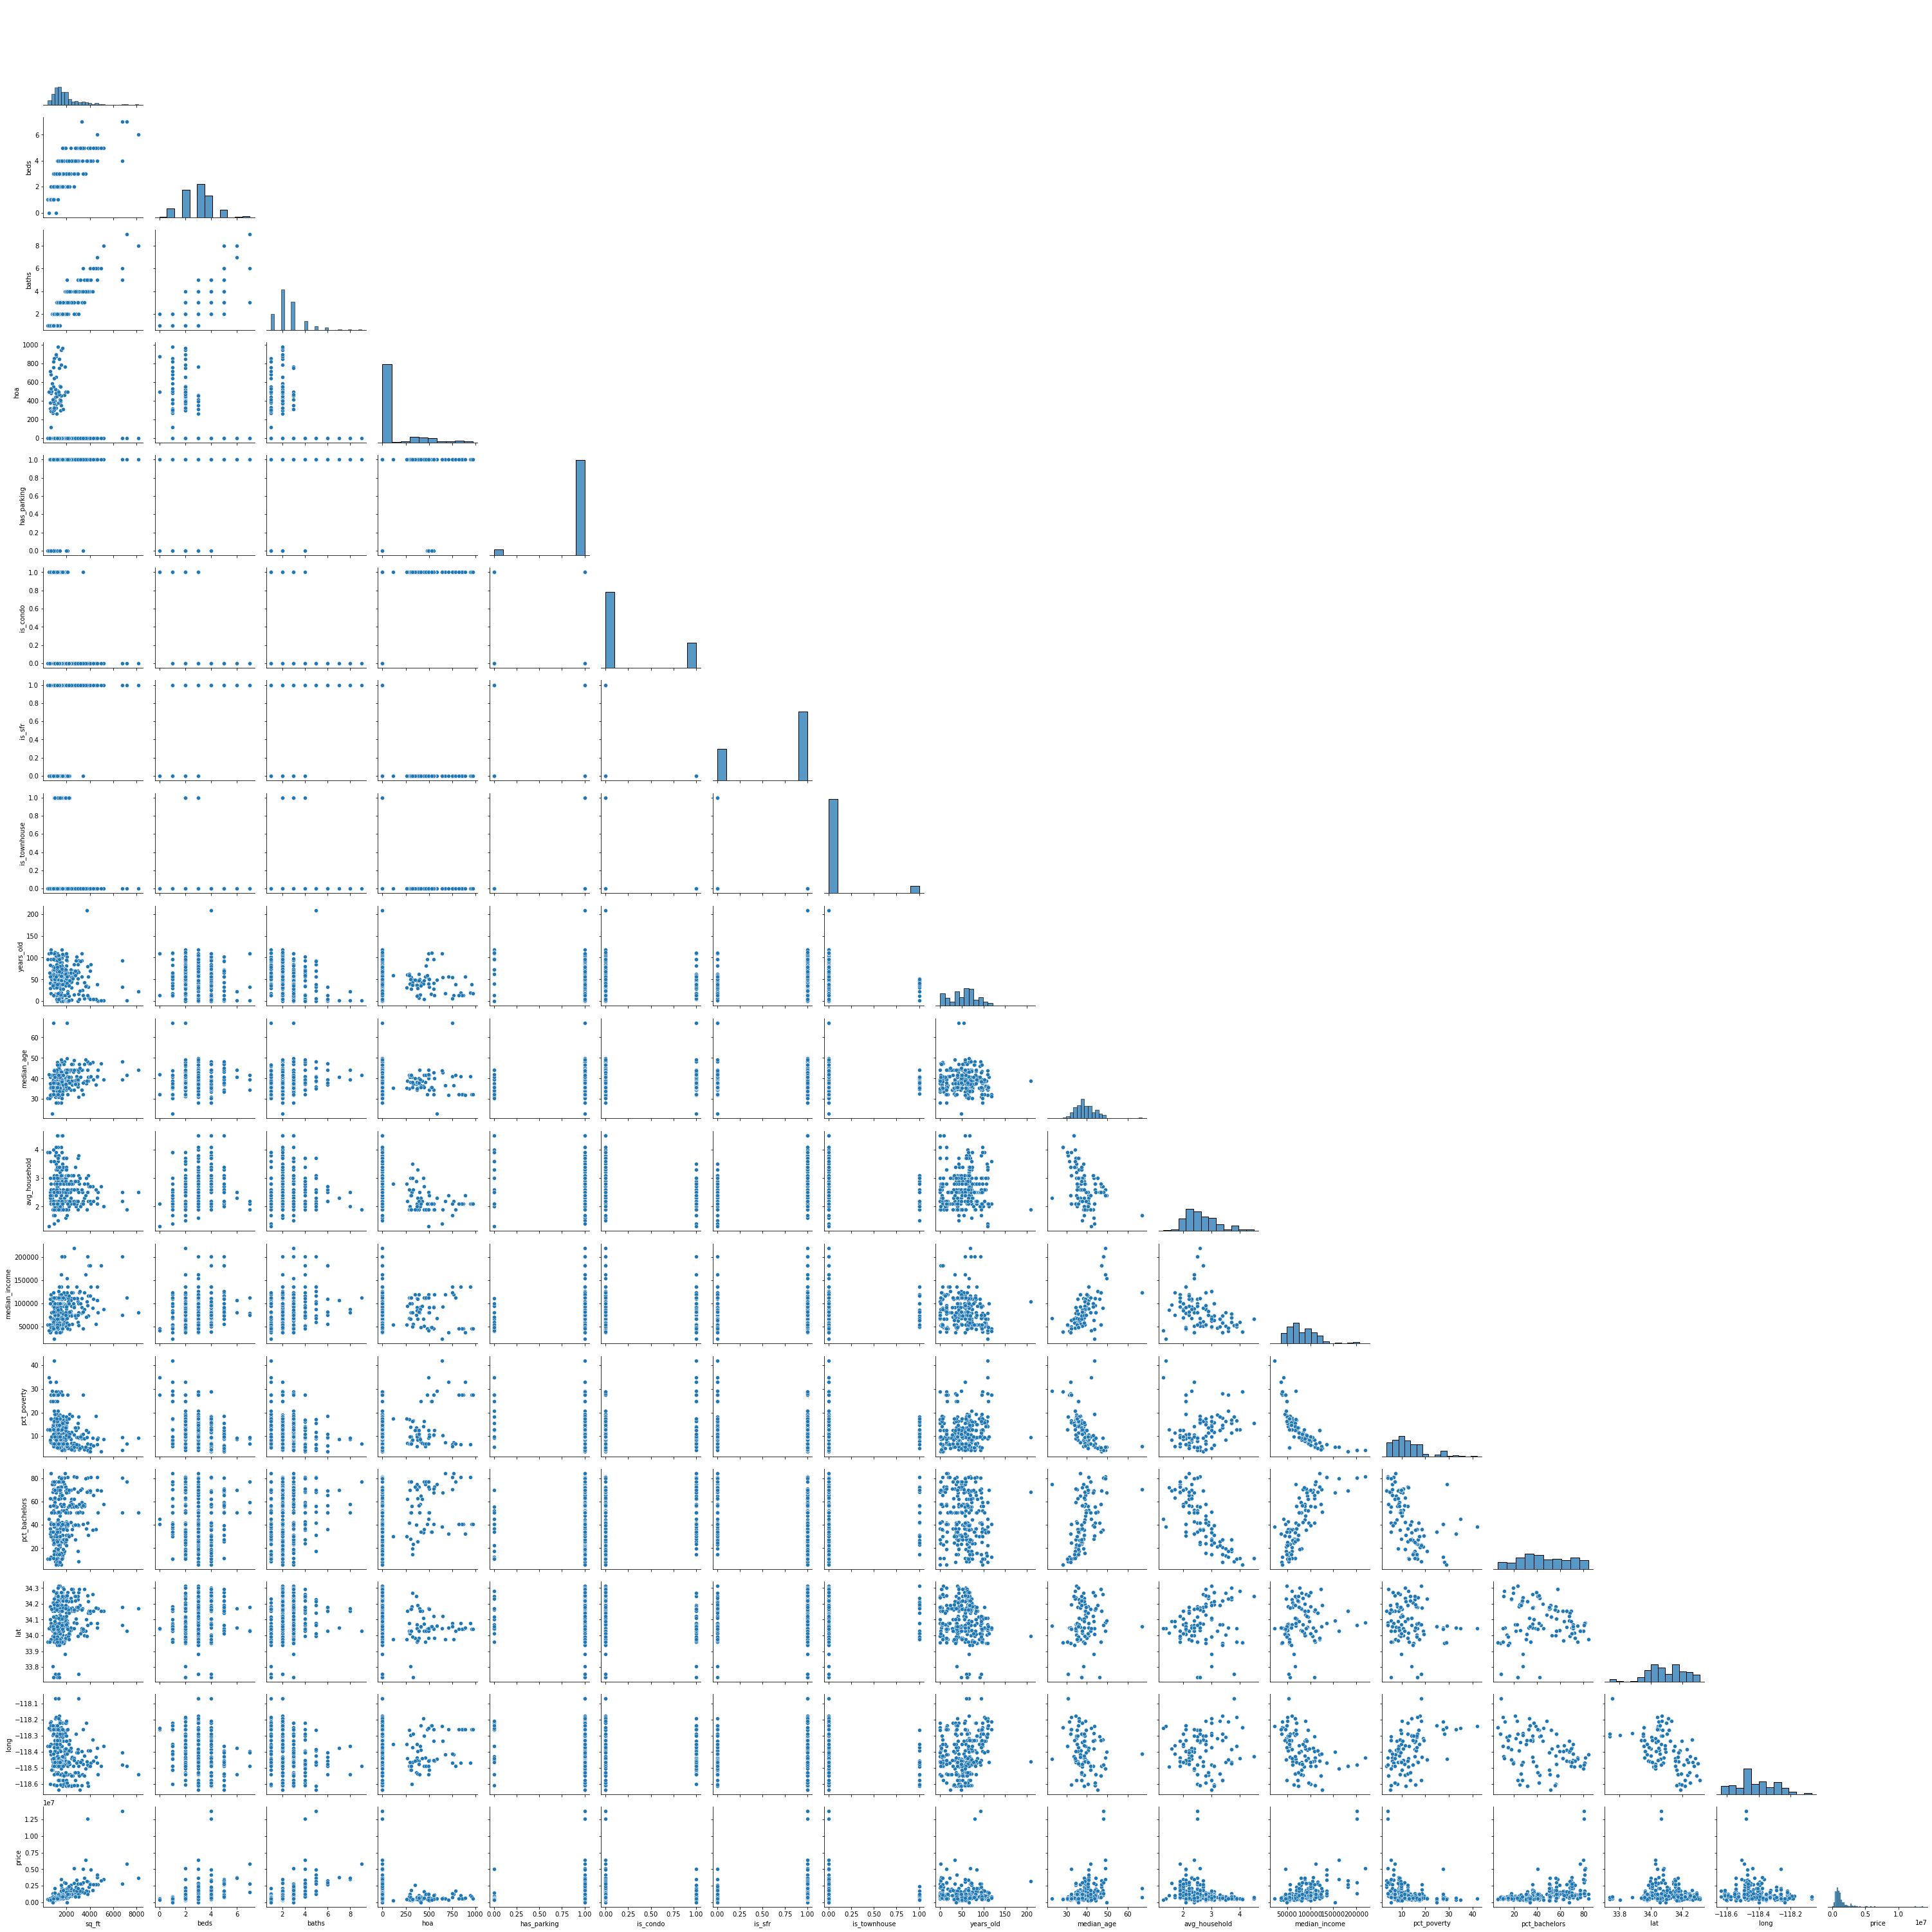

In [15]:
sns.pairplot(df, corner=True);

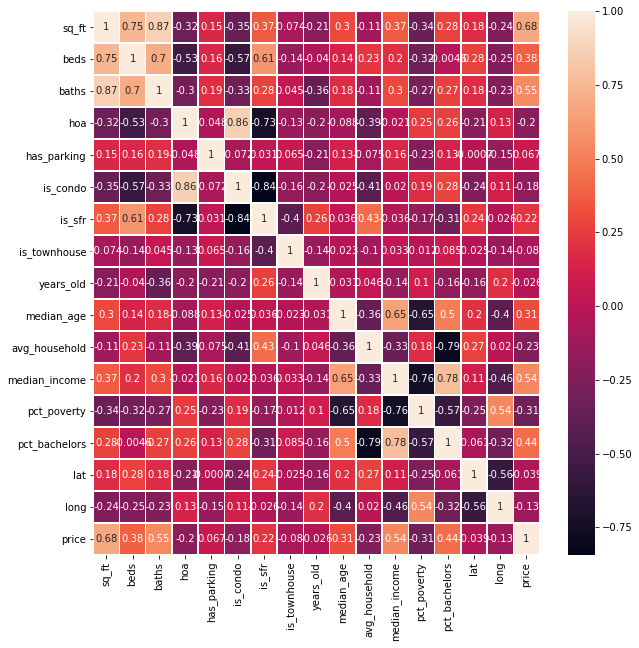

In [16]:
corrMatrix = df.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax);

### Variance Inflation Factor

We can use the correlation plot above to capture *collinearity* by gauging the magnitudes of the correlation coefficients between variables. But, to capture *multicollinearity*, it is best to use the [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF). 

In [17]:
drop_cols = ['address', 'price', 'zip_code', 'url', 'zip_usa', 'gcode', 'lat', 'long']
df_X = df.drop(drop_cols, axis =1)

In [18]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [19]:
# We only analyze the VIF for predictors
vif(df_X)

sq_ft              5.646260
beds               4.005402
baths              5.682427
hoa                4.345098
has_parking        1.138444
is_condo         210.154640
is_sfr           584.712816
is_townhouse      58.222443
years_old          1.630406
median_age         2.924290
avg_household      9.270807
median_income      9.323201
pct_poverty        3.763918
pct_bachelors     19.543308
dtype: float64

In [20]:
drop_cols2 = ['hoa','median_age', 'has_parking', 'is_townhouse']
df_X = df_X.drop(drop_cols2, axis =1)
vif(df_X)

sq_ft            20.850978
beds             28.544846
baths            27.677189
is_condo          4.953304
is_sfr           13.496346
years_old         5.686895
avg_household    37.070400
median_income    47.674372
pct_poverty      10.101321
pct_bachelors    34.739924
dtype: float64

These are better. A [rule of thumb](https://en.wikipedia.org/wiki/Variance_inflation_factor#Step_three) is to keep each VIF below 10, but take that with a grain of salt ...

# Ordinary Least Squares Regression


In [21]:
df_X.columns

Index(['sq_ft', 'beds', 'baths', 'is_condo', 'is_sfr', 'years_old',
       'avg_household', 'median_income', 'pct_poverty', 'pct_bachelors'],
      dtype='object')

In [22]:
X_data = df_X
y_data = df['price']

# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))

OLS
Train:  0.693
Val:  0.356


### Diagnostic Plotting

Before we move on, let's diagnose our model with a few diagnostic plots.

**Use plots and domain validation (*i.e., does it make sense in context?*) to determine if your model is "good."**

In [23]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [24]:
#Create the model
model = sm.OLS(y_data, sm.add_constant(X_data)) 
#Fit
fit = model.fit()
#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     52.17
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           2.82e-58
Time:                        09:40:48   Log-Likelihood:                -4383.8
No. Observations:                 292   AIC:                             8790.
Df Residuals:                     281   BIC:                             8830.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.102e+06   8.01e+05     -3.873      0.000   -4.68e+06   -1.53e+06
sq_ft           874.5589    100.670      8.687      0.000     676.396    1072.721
beds          -3.409e+05      8e+04     -4.260      0.000   -4.98e+05   -1.83e+05
baths          5.413e+04   8.72e+04      0.621      0.535   -1.17e+05    2.26e+05
is_condo       2.504e+04   2.17e+05      0.115      0.908   -4.03e+05    4.53e+05
is_sfr         4.889e+05   2.15e+05      2.276      0.024     6.6e+04    9.12e+05
years_old      6237.8985   1892.251      3.297      0.001    2513.111    9962.686
avg_household   6.48e+04   2.02e+05      0.320      0.749   -3.33e+05    4.63e+05
median_income    21.4190      3.836      5.584      0.000      13.868      28.970
pct_poverty    6.091e+04   1.22e+04      4.977      0.000    3.68e+04     8.5e+04
pct_bachelors  5526.7335   8733.632      0.633      0.527   -1.17e+04    2.27e+04
==============================================================================
Omnibus:                      282.730   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13790.593
Skew:                           3.731   Prob(JB):                         0.00
Kurtosis:                      35.830   Cond. No.                     1.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

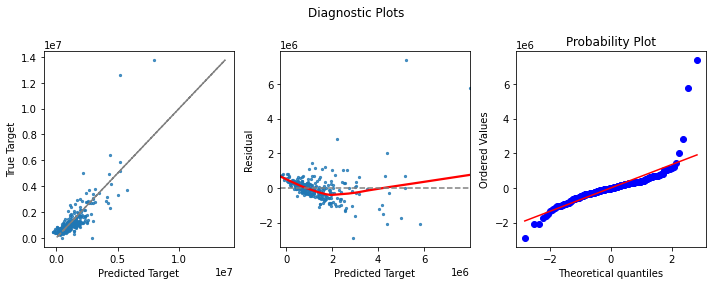

In [25]:
diagnostic_plots(fit.fittedvalues, y_data, fit.resid)

In [26]:
resid = {'address': df['address'],'y_pred':fit.fittedvalues,'y_actual':y_data, 'residual': fit.resid}
resid_df=pd.DataFrame(resid)
resid_df

,address,y_pred,y_actual,residual
0,"1135 W 185th St, Gardena, CA 90248, USA",8.916719e+05,800000.0,-91671.863720
1,"9631 Compton Ave, Los Angeles, CA 90002, USA",4.049954e+05,610000.0,205004.588554
2,"8701 Delgany Ave UNIT 304, Los Angeles, CA 902...",1.239246e+06,1125000.0,-114245.820070
3,"7904 Topanga Canyon Blvd UNIT 7, Canoga Park, ...",3.755550e+05,542300.0,166745.039168
4,"21917 Lopez St, Woodland Hills, CA 91364, USA",9.431408e+05,902000.0,-41140.788758
...,...,...,...,...
287,"222 S Central Ave APT 238, Los Angeles, CA 900...",4.794929e+05,2000.0,-477492.871727
288,"1130 S Flower St APT 306, Los Angeles, CA 9001...",9.266296e+05,605000.0,-321629.649196
289,"1130 S Flower St APT 402, Los Angeles, CA 9001...",1.354333e+06,1280000.0,-74332.775269
290,"880 W 1st St APT 211, Los Angeles, CA 90012, USA",5.446020e+05,549000.0,4397.970232


In [27]:
resid_df['abs_residual'] = np.abs(resid_df['residual'])
resid_df.sort_values(by='abs_residual',ascending=False).head(10)

,address,y_pred,y_actual,residual,abs_residual
157,"992 Napoli Dr, Pacific Palisades, CA 90272, USA",5.225908e+06,12600000.0,7.374092e+06,7.374092e+06
181,"1650 Amalfi Dr, Pacific Palisades, CA 90272, USA",7.983059e+06,13750000.0,5.766941e+06,5.766941e+06
91,"2201 Coldwater Canyon Dr, Beverly Hills, CA 90...",2.890890e+06,7100.0,-2.883790e+06,2.883790e+06
280,"1100 S Hope St APT 1904, Los Angeles, CA 90015...",2.201360e+06,5000000.0,2.798640e+06,2.798640e+06
46,"5435 Donna Ave, Tarzana, CA 91356, USA",5.804604e+06,3710000.0,-2.094604e+06,2.094604e+06
66,"15732 Milbank St, Encino, CA 91436, USA",4.371779e+06,2300000.0,-2.071779e+06,2.071779e+06
243,"1002 Alta Ave, Santa Monica, CA 90402, USA",4.368953e+06,6402725.0,2.033772e+06,2.033772e+06
71,"4943 Haskell Ave, Encino, CA 91436, USA",5.005090e+06,3290000.0,-1.715090e+06,1.715090e+06
233,"17368 W Sunset Blvd APT 206, Pacific Palisades...",2.977137e+06,1345000.0,-1.632137e+06,1.632137e+06
162,"5101 Rubio Ave, Encino, CA 91436, USA",4.200085e+06,2710000.0,-1.490085e+06,1.490085e+06


In [28]:
resid_df.abs_residual.mean()

452477.784006424

We underestimated [this property](https://www.zillow.com/homedetails/992-Napoli-Dr-Pacific-Palisades-CA-90272/20538957_zpid/) in the Pacific Palisades by over $7 million. We notice thelot size is 0.48 acres, and sits just __ from the beach.
    
We also underestimated [this property](https://www.zillow.com/homedetails/1650-Amalfi-Dr-Pacific-Palisades-CA-90272/20546591_zpid/) by almost $6 million. We notice the property sits on a 0.42 acre lot just __ from the beach.

We also notice that our estimate for [this property](https://www.zillow.com/homedetails/2201-Coldwater-Canyon-Dr-Beverly-Hills-CA-90210/20533801_zpid/) was wildly off since it sold for just over $7,000. 

In [29]:
resid_df.sort_values(by='y_actual',ascending=False).head(3)

,address,y_pred,y_actual,residual,abs_residual
181,"1650 Amalfi Dr, Pacific Palisades, CA 90272, USA",7.983059e+06,13750000.0,5.766941e+06,5.766941e+06
157,"992 Napoli Dr, Pacific Palisades, CA 90272, USA",5.225908e+06,12600000.0,7.374092e+06,7.374092e+06
243,"1002 Alta Ave, Santa Monica, CA 90402, USA",4.368953e+06,6402725.0,2.033772e+06,2.033772e+06


In [30]:
resid_df.sort_values(by='y_actual',ascending=True).head(3)

,address,y_pred,y_actual,residual,abs_residual
287,"222 S Central Ave APT 238, Los Angeles, CA 900...",4.794929e+05,2000.0,-4.774929e+05,4.774929e+05
91,"2201 Coldwater Canyon Dr, Beverly Hills, CA 90...",2.890890e+06,7100.0,-2.883790e+06,2.883790e+06
201,"5460 White Oak Ave UNIT A227, Encino, CA 91316...",3.074047e+05,242000.0,-6.540468e+04,6.540468e+04


They are also our only properties worth over $10 million. For the purposes of this analysis, we can feel comfortable excluding these outliers in our regression.

In additionto excluding properties that sold for over $10 million, we will exclude those that sold for less than $10,000.

In [31]:
df = df[(df.price < 10000000) & (df.price > 10000)]
df.shape

(288, 22)

In [32]:
df_X = df.drop(drop_cols, axis =1)
df_X = df_X.drop(drop_cols2, axis =1)
df_X

,sq_ft,beds,baths,is_condo,is_sfr,years_old,avg_household,median_income,pct_poverty,pct_bachelors
0,1866.0,3.0,3.0,0,1,67.0,3.0,64253.0,9.7,27.9
1,1522.0,4.0,3.0,0,1,0.0,4.1,38987.0,28.8,6.1
2,1785.0,3.0,3.0,1,0,57.0,1.9,110698.0,5.8,74.7
3,1626.0,3.0,3.0,0,0,40.0,3.1,73724.0,11.7,31.5
4,1014.0,3.0,1.0,0,1,72.0,2.6,111075.0,5.5,55.5
...,...,...,...,...,...,...,...,...,...,...
286,1621.0,2.0,2.0,1,0,38.0,2.1,45894.0,27.6,40.5
288,1258.0,1.0,2.0,1,0,18.0,2.1,45894.0,27.6,40.5
289,2075.0,2.0,3.0,1,0,18.0,2.1,45894.0,27.6,40.5
290,1217.0,2.0,2.0,1,0,39.0,2.1,49174.0,24.8,34.0


In [33]:
X_data = df_X
y_data = df['price']

model = sm.OLS(y_data, sm.add_constant(X_data)) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     75.43
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           4.04e-73
Time:                        09:40:50   Log-Likelihood:                -4177.3
No. Observations:                 288   AIC:                             8377.
Df Residuals:                     277   BIC:                             8417.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.832e+06   4.87e+05     -3.761      0.000   -2.79e+06   -8.73e+05
sq_ft           493.6607     64.750      7.624      0.000     366.196     621.126
beds          -1.719e+05   4.93e+04     -3.490      0.001   -2.69e+05   -7.49e+04
baths           1.47e+05   5.29e+04      2.778      0.006    4.28e+04    2.51e+05
is_condo        6.84e+04   1.31e+05      0.523      0.601   -1.89e+05    3.26e+05
is_sfr         5.772e+05   1.29e+05      4.459      0.000    3.22e+05    8.32e+05
years_old      2544.0683   1155.414      2.202      0.028     269.561    4818.576
avg_household -2.334e+04   1.23e+05     -0.190      0.849   -2.65e+05    2.18e+05
median_income     9.0275      2.437      3.705      0.000       4.230      13.825
pct_poverty    3.613e+04   7489.767      4.824      0.000    2.14e+04    5.09e+04
pct_bachelors  1.338e+04   5314.985      2.518      0.012    2920.668    2.38e+04
==============================================================================
Omnibus:                      168.479   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1674.763
Skew:                           2.199   Prob(JB):                         0.00
Kurtosis:                      13.964   Cond. No.                     1.53e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
X_data = df_X.drop(columns=['avg_household', 'is_condo'])
y_data = df['price']

model = sm.OLS(y_data, sm.add_constant(X_data)) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     94.83
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           4.94e-75
Time:                        09:40:50   Log-Likelihood:                -4177.4
No. Observations:                 288   AIC:                             8373.
Df Residuals:                     279   BIC:                             8406.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.865e+06   2.47e+05     -7.550      0.000   -2.35e+06   -1.38e+06
sq_ft           500.4162     62.459      8.012      0.000     377.465     623.367
beds          -1.742e+05   4.76e+04     -3.661      0.000   -2.68e+05   -8.06e+04
baths          1.403e+05   5.13e+04      2.735      0.007    3.93e+04    2.41e+05
is_sfr         5.299e+05    9.4e+04      5.640      0.000    3.45e+05    7.15e+05
years_old      2525.3727   1122.636      2.250      0.025     315.460    4735.286
median_income     8.7311      1.965      4.444      0.000       4.864      12.599
pct_poverty    3.677e+04   7373.027      4.988      0.000    2.23e+04    5.13e+04
pct_bachelors  1.449e+04   2743.429      5.280      0.000    9084.802    1.99e+04
==============================================================================
Omnibus:                      168.661   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1683.704
Skew:                           2.201   Prob(JB):                         0.00
Kurtosis:                      13.997   Cond. No.                     7.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

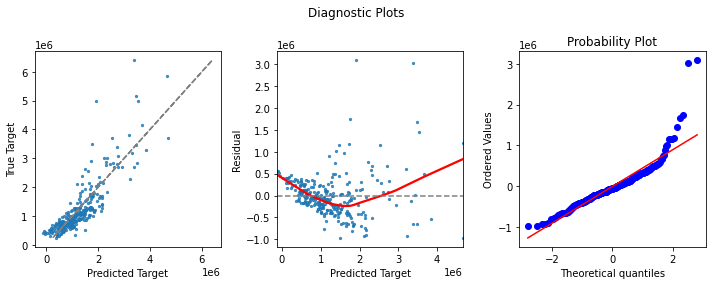

In [35]:
diagnostic_plots(fit.fittedvalues, y_data, fit.resid)

In [36]:
resid = {'address': df['address'],'y_pred':fit.fittedvalues,'y_actual':y_data, 'residual': fit.resid}
resid_df=pd.DataFrame(resid)
resid_df['abs_residual'] = np.abs(resid_df['residual'])
resid_df.sort_values(by='abs_residual',ascending=False).head(10)

,address,y_pred,y_actual,residual,abs_residual
280,"1100 S Hope St APT 1904, Los Angeles, CA 90015...",1.912145e+06,5000000.0,3.087855e+06,3.087855e+06
243,"1002 Alta Ave, Santa Monica, CA 90402, USA",3.378248e+06,6402725.0,3.024477e+06,3.024477e+06
249,"535 Ocean Ave UNIT 7D, Santa Monica, CA 90402,...",1.748663e+06,3500000.0,1.751337e+06,1.751337e+06
21,"680 Sarbonne Rd, Los Angeles, CA 90077, USA",3.472428e+06,5148000.0,1.675572e+06,1.675572e+06
119,"2237 Mandeville Canyon Rd, Los Angeles, CA 900...",3.530719e+06,4980000.0,1.449281e+06,1.449281e+06
244,"1014 Berkeley St, Santa Monica, CA 90403, USA",4.661468e+06,5850000.0,1.188532e+06,1.188532e+06
199,"9151 Warbler Pl, West Hollywood, CA 90069, USA",1.730409e+06,2900000.0,1.169591e+06,1.169591e+06
232,"1 Driftwood St APT 1, Marina Del Rey, CA 90292...",1.474529e+06,2627500.0,1.152971e+06,1.152971e+06
197,"3524 Mountain View Ave, Los Angeles, CA 90066,...",2.537957e+06,3688000.0,1.150043e+06,1.150043e+06
256,"2215 5th St #B, Santa Monica, CA 90405, USA",1.391090e+06,2400000.0,1.008910e+06,1.008910e+06


Here is a look at the top 3 we under-valued in our model: 
- [19th floor condo with sweeping city views](https://www.zillow.com/homedetails/1100-S-Hope-St-APT-1904-Los-Angeles-CA-90015/81959314_zpid/?)
- [3 bed, 4 bath oasis just 1 mile from beach](https://www.zillow.com/homedetails/1002-Alta-Ave-Santa-Monica-CA-90402/20477953_zpid/)
- [This literal beachfront property](https://www.zillow.com/homedetails/535-Ocean-Ave-UNIT-7D-Santa-Monica-CA-90402/20486431_zpid/)

We'll have to accept some level of bias in our model, given that we are missing useful features like `has_view` and `beach_proximity`. `lot_size` would also be useful in future models.

In [37]:
coastal_zips = ['90802', '90803', '90822', '90731', '90732', '90275','90274','90277','90254','90266','90245','90293', '90292','90291','90405','90401', '90403','90402', '90272', '90265']

In [38]:
df['near_ocean'] = df['zip_code'].apply(lambda x: 1 if x in coastal_zips else 0)

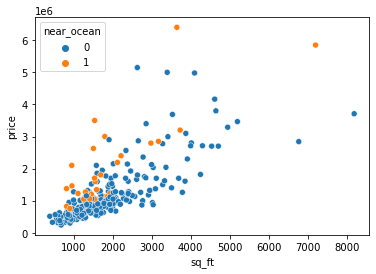

In [39]:
sns.scatterplot(data=df, x='sq_ft', y='price', hue='near_ocean', legend='brief');

In [40]:
df.shape

(288, 23)

In [41]:
drop_cols2 = ['hoa','median_age', 'has_parking', 'is_townhouse', 'avg_household', 'is_condo']
df_X = df.drop(drop_cols, axis =1)
df_X = df_X.drop(drop_cols2, axis =1)
df_X.head()

,sq_ft,beds,baths,is_sfr,years_old,median_income,pct_poverty,pct_bachelors,near_ocean
0,1866.0,3.0,3.0,1,67.0,64253.0,9.7,27.9,0
1,1522.0,4.0,3.0,1,0.0,38987.0,28.8,6.1,0
2,1785.0,3.0,3.0,0,57.0,110698.0,5.8,74.7,1
3,1626.0,3.0,3.0,0,40.0,73724.0,11.7,31.5,0
4,1014.0,3.0,1.0,1,72.0,111075.0,5.5,55.5,0


In [42]:
X_data = df_X
y_data = df['price']

model = sm.OLS(y_data, sm.add_constant(X_data)) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     87.75
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           5.90e-76
Time:                        09:40:51   Log-Likelihood:                -4172.8
No. Observations:                 288   AIC:                             8366.
Df Residuals:                     278   BIC:                             8402.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.738e+06   2.47e+05     -7.031      0.000   -2.22e+06   -1.25e+06
sq_ft           528.1412     62.255      8.484      0.000     405.591     650.692
beds          -1.771e+05   4.69e+04     -3.775      0.000    -2.7e+05   -8.48e+04
baths          1.205e+05    5.1e+04      2.363      0.019    2.01e+04    2.21e+05
is_sfr         5.685e+05   9.35e+04      6.080      0.000    3.84e+05    7.53e+05
years_old      2082.2522   1116.403      1.865      0.063    -115.426    4279.930
median_income     7.7889      1.962      3.970      0.000       3.927      11.651
pct_poverty    3.491e+04   7294.452      4.786      0.000    2.06e+04    4.93e+04
pct_bachelors   1.32e+04   2737.881      4.821      0.000    7809.513    1.86e+04
near_ocean     2.955e+05    9.8e+04      3.016      0.003    1.03e+05    4.88e+05
==============================================================================
Omnibus:                      165.804   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1626.178
Skew:                           2.157   Prob(JB):                         0.00
Kurtosis:                      13.812   Cond. No.                     7.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))

OLS
Train:  0.709
Val:  0.857


## Evaluating our Regression Model

In [44]:
# extract feature coefficients and intercept from fit model
print(lr.intercept_)
print(lr.coef_)

-1832661.1236130737
[ 4.85213021e+02 -2.44138077e+05  1.86311266e+05  6.81472114e+05
  2.04123290e+03  8.34602884e+00  3.81278721e+04  1.42333676e+04
  3.01118919e+05]


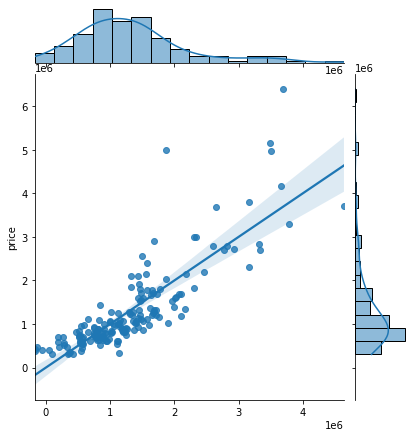

In [45]:
preds = lr.predict(X_train) # generate predictions (on training data) using fit model
sns.jointplot(x=preds,y=y_train, kind='reg');

In [46]:
rmse = mean_squared_error(y_train, preds, squared=False)
mae = mean_absolute_error(y_train, preds)
print('RMSE: ', rmse.round(3))
print('MAE: ', mae.round(3))

RMSE:  530052.544
MAE:  355690.896


## Feature Engineering

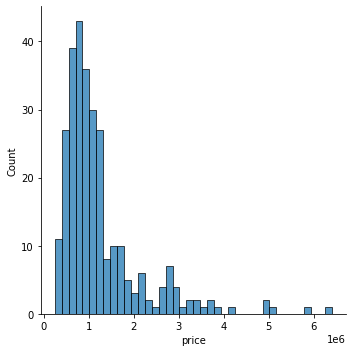

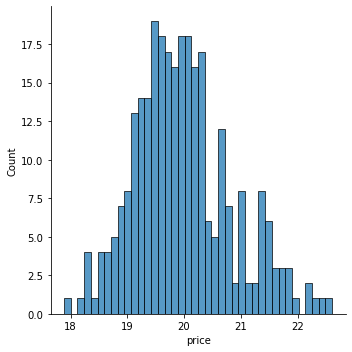

In [47]:
sns.displot(y_data, fill=True, bins=40)
sns.displot(np.log2(y_data), fill=True, bins=40);

In [48]:
df_X.shape

(288, 9)

In [49]:
X_data = df_X
y_data = np.log2(df['price'])

model = sm.OLS(y_data, sm.add_constant(X_data)) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     133.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           1.30e-95
Time:                        09:40:53   Log-Likelihood:                -123.46
No. Observations:                 288   AIC:                             266.9
Df Residuals:                     278   BIC:                             303.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.1505      0.194     88.618      0.000      16.769      17.531
sq_ft             0.0003   4.87e-05      6.909      0.000       0.000       0.000
beds             -0.0124      0.037     -0.338      0.735      -0.085       0.060
baths             0.0682      0.040      1.709      0.089      -0.010       0.147
is_sfr            0.7873      0.073     10.755      0.000       0.643       0.931
years_old         0.0003      0.001      0.380      0.704      -0.001       0.002
median_income  2.269e-06   1.54e-06      1.477      0.141   -7.54e-07    5.29e-06
pct_poverty       0.0222      0.006      3.896      0.000       0.011       0.033
pct_bachelors     0.0217      0.002     10.110      0.000       0.017       0.026
near_ocean        0.3408      0.077      4.442      0.000       0.190       0.492
==============================================================================
Omnibus:                       58.351   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.683
Skew:                           0.807   Prob(JB):                     1.46e-47
Kurtosis:                       6.920   Cond. No.                     7.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
print('OLS with log2(price)')
print('Train: ', lr.score(X_train,y_train).round(3))
print('Val: ', lr.score(X_val,y_val).round(3))
print('Test: ', lr.score(X_test, y_test).round(3))

OLS with log2(price)
Train:  0.815
Val:  0.828
Test:  0.77


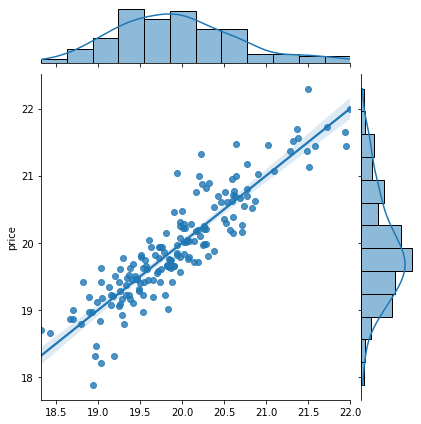

In [51]:
preds = lr.predict(X_train) # generate predictions (on training data) using fit model
sns.jointplot(x=preds,y=y_train, kind='reg');

In [52]:
rmse = mean_squared_error(y_train, preds, squared=False)
mae = mean_absolute_error(y_train, preds)
print('RMSE: ', rmse.round(3))
print('MAE: ', mae.round(3))

RMSE:  0.344
MAE:  0.262


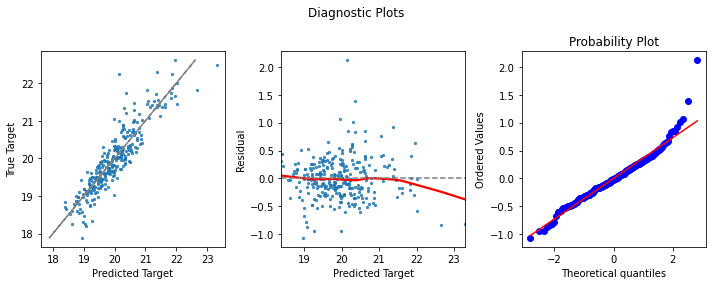

In [53]:
diagnostic_plots(fit.fittedvalues, y_data, fit.resid)

a note on interpretation:https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va

Log Y and X -- a one unit increase in X would lead to a 𝛽∗100 % increase/decrease in Y 


In [54]:
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization

Now we need some model setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

In [55]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [56]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.828
Ridge Regression val R^2: 0.829
Degree 2 polynomial regression val R^2: 0.697


So having run this validation step, we see that the evidence points to simple linear regression being the best model. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

In [57]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.765


Here we will break the data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation.

Remember that the idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. 

As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

In [58]:
from sklearn.model_selection import KFold

X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [59]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 70)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.81, 0.807, 0.726, 0.788, 0.844]
Ridge scores: 	[0.812, 0.808, 0.726, 0.789, 0.843] 

Simple mean cv r^2: 0.795 +- 0.039
Ridge mean cv r^2: 0.796 +- 0.039


In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
# 3-, 4-, and 5-fold cross-validation 
lm = LinearRegression()
lm_reg = Ridge(alpha=1)

simple_mean_r2s = []
simple_std_r2s = []
ridge_mean_r2s = []
ridge_std_r2s = []

for i in [3, 4, 5]:
    scores_lm = cross_val_score(lm, X, y, cv=i, scoring='r2')
    scores_lm_reg = cross_val_score(lm_reg, X, y, cv=i, scoring='r2')

    print(f'{i}-fold cross-validation:\n')
    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print(f'Simple scores: \t{-scores_lm}')
    print(f'Ridge scores: \t{-scores_lm_reg} \n')

    print(f'Simple mean cv r^2: {np.mean(-scores_lm):.3f} +- {np.std(-scores_lm):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(-scores_lm_reg):.3f} +- {np.std(-scores_lm_reg):.3f}\n')
    
    print('----------------------\n')
    
    simple_mean_r2s.append(np.mean(-scores_lm))
    simple_std_r2s.append(np.std(-scores_lm))
    ridge_mean_r2s.append(np.mean(-scores_lm_reg))
    ridge_std_r2s.append(np.std(-scores_lm_reg))

print('Repeated Cross Validation Results: \n')
print(f'Simple mean cv r^2: {np.mean(simple_mean_r2s):.3f} +- {np.std(simple_std_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(ridge_mean_r2s):.3f} +- {np.std(ridge_std_r2s):.3f}')

3-fold cross-validation:

Simple scores: 	[-0.81512989 -0.76660049 -0.78663237]
Ridge scores: 	[-0.81297814 -0.76820075 -0.78726145] 

Simple mean cv r^2: -0.789 +- 0.020
Ridge mean cv r^2: -0.789 +- 0.018

----------------------

4-fold cross-validation:

Simple scores: 	[-0.83861667 -0.8607493  -0.60623632 -0.78702854]
Ridge scores: 	[-0.83734654 -0.85839849 -0.6096893  -0.78873037] 

Simple mean cv r^2: -0.773 +- 0.100
Ridge mean cv r^2: -0.774 +- 0.098

----------------------

5-fold cross-validation:

Simple scores: 	[-0.8173464  -0.80878789 -0.69022743 -0.71388912 -0.79801348]
Ridge scores: 	[-0.82011854 -0.8049059  -0.69682096 -0.71125379 -0.7982735 ] 

Simple mean cv r^2: -0.766 +- 0.053
Ridge mean cv r^2: -0.766 +- 0.052

----------------------

Repeated Cross Validation Results: 

Simple mean cv r^2: -0.776 +- 0.033
Ridge mean cv r^2: -0.776 +- 0.033


## Standard-scaling Features (a must for regularization!)

In [62]:
df_X.values

array([[1.866e+03, 3.000e+00, 3.000e+00, ..., 9.700e+00, 2.790e+01,
        0.000e+00],
       [1.522e+03, 4.000e+00, 3.000e+00, ..., 2.880e+01, 6.100e+00,
        0.000e+00],
       [1.785e+03, 3.000e+00, 3.000e+00, ..., 5.800e+00, 7.470e+01,
        1.000e+00],
       ...,
       [2.075e+03, 2.000e+00, 3.000e+00, ..., 2.760e+01, 4.050e+01,
        0.000e+00],
       [1.217e+03, 2.000e+00, 2.000e+00, ..., 2.480e+01, 3.400e+01,
        0.000e+00],
       [8.600e+02, 1.000e+00, 1.000e+00, ..., 2.760e+01, 4.050e+01,
        0.000e+00]])

In [63]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=10) #hold out 20% of the data for final testing

## Scale the data as before
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

# This is the best alpha value it found - not far from the value
# selected using simple validation
print(lasso_model.alpha_)

# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

# Find the MAE and R^2 on the test set using this model
mae = mean_absolute_error(y_test, test_set_pred)
r2 = r2_score(y_test, test_set_pred)

print(mae)
print(r2)

0.01663816886076129
0.26763041923491626
0.7941360041974499
